# 03. MLP, Multi-Layer Perceptron — 從數學到 PyTorch

## 0. Notebook Header
- 作者：Paul Yang
- 目的：理解神經網路如何解決非線性問題 (XOR)，並掌握反向傳播 (Backpropagation) 的精隨。
- 學會什麼：Hidden Layer, Activation Function, Chain Rule, PyTorch nn.Sequential

## 1. 為什麼需要神經網路？(The XOR Problem)
我們之前學的 Linear/Logistic Regression 只能畫「一條直線」來分類。
但是，如果資料長得像 **XOR (互斥或)** 這樣，一條線是切不開的：
- (0, 0) -> 0
- (1, 1) -> 0
- (0, 1) -> 1
- (1, 0) -> 1

我們需要「彎曲」的線，這就是 **Hidden Layer (隱藏層)** 和 **Non-linear Activation (非線性激活函數)** 的工作。

X Shape: (4, 2)
y Shape: (4, 1)


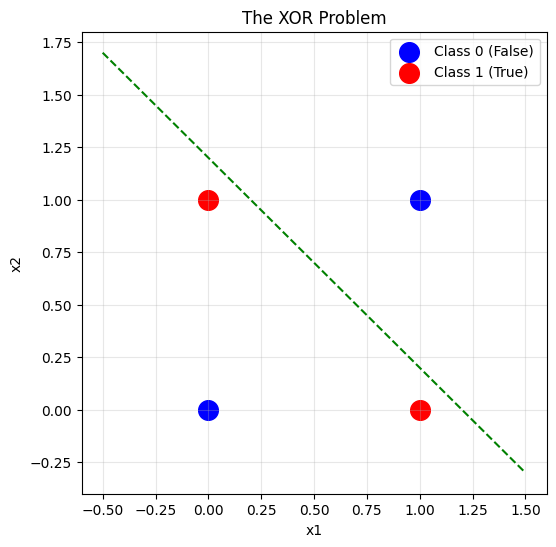

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 準備 XOR 資料
# 輸入 X: 4個點
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# 標籤 Y: XOR 的結果 (0, 1, 1, 0)
y = np.array([
    [0],
    [1],
    [1],
    [0]
])

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

fig, ax = plt.subplots(figsize=(6, 6))
# 2. 視覺化 XOR 問題

# 畫出 label 為 0 的點 (藍色)
ax.scatter(X[y.flatten()==0][:, 0], X[y.flatten()==0][:, 1], 
           color='blue', s=200, label='Class 0 (False)')

# 畫出 label 為 1 的點 (紅色)
ax.scatter(X[y.flatten()==1][:, 0], X[y.flatten()==1][:, 1], 
           color='red', s=200, label='Class 1 (True)')

ax.set_title("The XOR Problem")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.grid(True, alpha=0.3)

# 嘗試畫一條線看看能不能分開？(示意圖)
x_line = np.linspace(-0.5, 1.5, 100)
ax.plot(x_line, -x_line + 1.2, 'g--', label='Any Linear Line?') 

plt.show()

## 2.激活函數

### a. 純Python

In [7]:
import math

def step_function(x):
    return 1 if x>= 0 else 0

def relu(x):
    return max(0, x)

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

print(f"Step(0.5) = {step_function(0.5)}")   # 應該是 1
print(f"Step(-2) = {step_function(-2)}")     # 應該是 0
print(f"ReLU(3) = {relu(3)}")                 # 應該是 3
print(f"ReLU(-1) = {relu(-1)}")               # 應該是 0
print(f"Sigmoid(5) = {sigmoid(5)}")          # 應該接近 1
print(f"Sigmoid(-5) = {sigmoid(-5)}")        # 應該接近 0
print(f"Sigmoid(0) = {sigmoid(0)}")          # 應該是 0.5

Step(0.5) = 1
Step(-2) = 0
ReLU(3) = 3
ReLU(-1) = 0
Sigmoid(5) = 0.9933071490757153
Sigmoid(-5) = 0.0066928509242848554
Sigmoid(0) = 0.5


### b. Numpy
為了讓這些數學公式能同時處理一整批資料

In [8]:
import numpy as np

def sigmoid_np(x):
    return 1 / (1 + np.exp(-x)) 

## 初始化

In [9]:
import numpy as np
import matplotlib.pyplot as plt

w1 = np.random.randn(2, 2)  # 2 inputs, 2 neurons
b1 = np.random.randn(2)     # 2 neurons

w2 = np.random.randn(2, 1)  # 2 inputs, 1 output
b2 = np.random.randn(1)     # 1 output

print(f"W1: {w1.shape}, b1: {b1.shape}")
print(f"W2: {w2.shape}, b2: {b2.shape}")

W1: (2, 2), b1: (2,)
W2: (2, 1), b2: (1,)


1. Input ($X$) $\to$ Hidden Layer: 線性變換 ($Z_1$) + 非線性激活 ($A_1$)
2. Hidden Layer ($A_1$) $\to$ Output Layer: 線性變換 ($Z_2$) + 非線性激活 ($A_2$)

In [10]:
def forward(X, w1, b1, w2, b2):
    z1 = np.dot(X, w1) + b1      # 第一層的線性組合
    a1 = sigmoid_np(z1)          # 第一層的激活函數
    z2 = np.dot(a1, w2) + b2      # 第二層的線性組合
    a2 = sigmoid_np(z2)          # 第二層的激活函數
    return a1, a2

In [12]:
def backward(X, y, a1, a2, w2):
    m = X.shape[0]  # 樣本數量

    error2 = a2 - y  # 輸出層的誤差

    dw2 = np.dot(a1.T, error2) / m  # 第二層權重的梯度
    db2 = np.sum(error2, axis=0) / m  # 第二層偏置的梯度

    # 把誤差傳回第一層 (Backpropagate error)
    # 這裡要用到 Chain Rule:
    # (1) error2 乘上 w2 的轉置 (把責任分摊回去)
    # (2) 乘上 Sigmoid 的導數 (a1 * (1-a1))
    error1 = np.dot(error2, w2.T) * a1 * (1 - a1) 

    dw1 = np.dot(X.T, error1) / m  # 第一層權重的梯度
    db1 = np.sum(error1, axis=0) / m  # 第一層偏置的梯度

    return dw1, db1, dw2, db2

In [13]:
def train(X, y, epochs, learning_rate):
    np.random.seed(42)  # For reproducibility
    w1 = np.random.randn(2, 2)  # 2 inputs, 2 neurons
    b1 = np.random.randn(2)     # 2 neurons

    w2 = np.random.randn(2, 1)  # 2 inputs, 1 output
    b2 = np.random.randn(1)     # 1 output

    loss_history = []
    for epoch in range(epochs):
        a1 , a2 = forward(X, w1, b1, w2, b2)
        dw1, db1, dw2, db2 = backward(X, y, a1, a2, w2)

        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2

        loss =  -(y * np.log(a2 + 1e-8) + (1 - y) * np.log(1 - a2 + 1e-8)).mean()
        loss_history.append(loss)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return w1, b1, w2, b2, loss_history


In [14]:
w1, b1, w2, b2, loss_history = train(X, y, epochs=10000, learning_rate=0.1)

Epoch 0, Loss: 0.7983
Epoch 1000, Loss: 0.6842
Epoch 2000, Loss: 0.6020
Epoch 3000, Loss: 0.4744
Epoch 4000, Loss: 0.2589
Epoch 5000, Loss: 0.0932
Epoch 6000, Loss: 0.0510
Epoch 7000, Loss: 0.0344
Epoch 8000, Loss: 0.0258
Epoch 9000, Loss: 0.0205


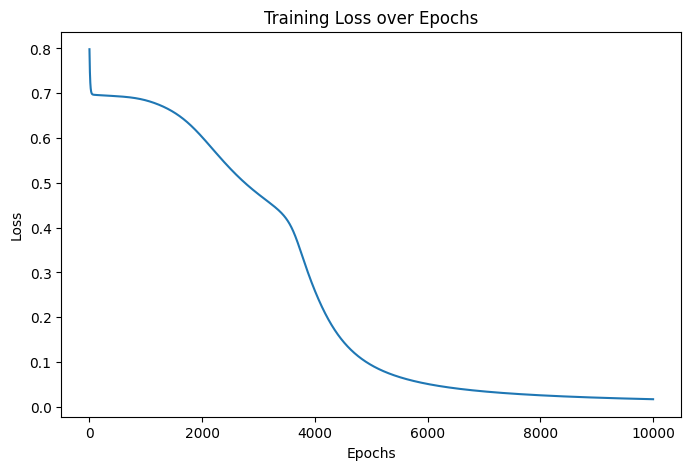

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(loss_history)             
ax.set_title("Training Loss over Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.show()

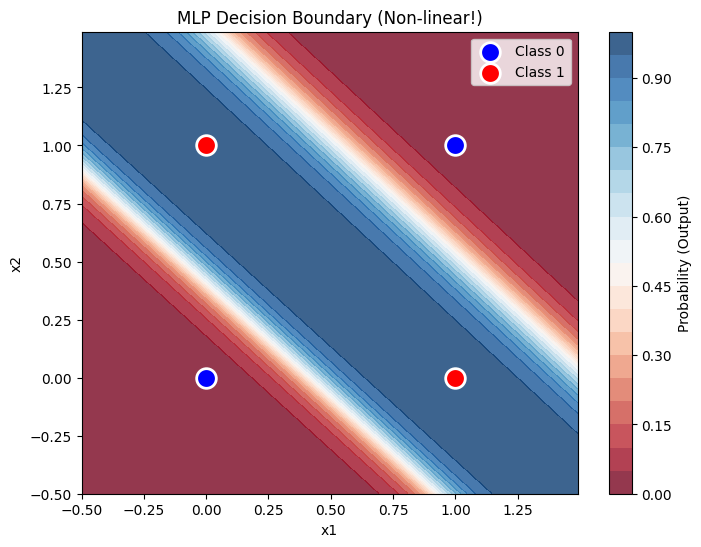

In [20]:
def plot_decision_boundary(X, y, w1, b1, w2, b2):
    # 1. 設定網格範圍 (比資料範圍稍微大一點)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01  # 網格密度
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # 2. 把網格點攤平，丟進模型預測
    grid_inputs = np.c_[xx.ravel(), yy.ravel()]
    
    # 注意：這裡我們只需要最終輸出 a2 (機率)
    _, probs = forward(grid_inputs, w1, b1, w2, b2)
    
    # 3. 把預測結果 reshape 回網格形狀
    probs = probs.reshape(xx.shape)
    
    # 4. 畫圖
    fig, ax = plt.subplots(figsize=(8, 6))

    # 畫出決策區域 (Contour Plot)
    # RdBu 是一個紅藍配色，中間白色代表 0.5 (決策邊界)
    cont = ax.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.8)
    fig.colorbar(cont, ax=ax, label='Probability (Output)')

    # 畫出原始資料點
    ax.scatter(X[y.flatten()==0][:, 0], X[y.flatten()==0][:, 1], 
               color='blue', s=200, edgecolor='white', linewidth=2, label='Class 0')
    ax.scatter(X[y.flatten()==1][:, 0], X[y.flatten()==1][:, 1], 
               color='red', s=200, edgecolor='white', linewidth=2, label='Class 1')

    ax.set_title("MLP Decision Boundary (Non-linear!)")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    plt.show()

# 呼叫函式畫圖
plot_decision_boundary(X, y, w1, b1, w2, b2)

Hidden Layer Representations:
 [[5.25728835e-02 9.72182759e-04]
 [9.77873398e-01 8.40679668e-02]
 [9.74630943e-01 8.23778566e-02]
 [9.99967319e-01 8.94372963e-01]]


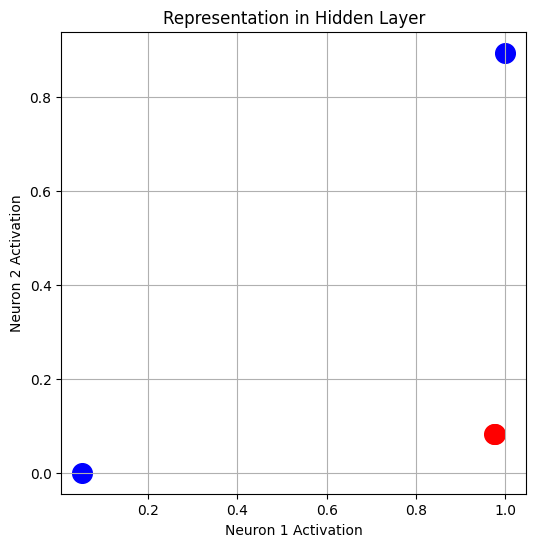

In [22]:
# 取得隱藏層的輸出 (a1)
hidden_features, _ = forward(X, w1, b1, w2, b2)

print("Hidden Layer Representations:\n", hidden_features)

fig, ax = plt.subplots(figsize=(6, 6))
# 畫出隱藏層空間中的點
ax.scatter(hidden_features[y.flatten()==0][:, 0], hidden_features[y.flatten()==0][:, 1], 
            color='blue', s=200, label='Class 0')
ax.scatter(hidden_features[y.flatten()==1][:, 0], hidden_features[y.flatten()==1][:, 1], 
            color='red', s=200, label='Class 1')

ax.set_title("Representation in Hidden Layer")
ax.set_xlabel("Neuron 1 Activation")
ax.set_ylabel("Neuron 2 Activation")
# ax.legend()
ax.grid(True)
plt.show()